Ensemble Model

In [11]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error


Load predictions and actuals dataframe

In [12]:
import os
import pandas as pd
from pathlib import Path

# Set the working directory
project_dir = Path(os.getcwd()).parent

# Define the path to the raw data folder relative to the project directory
data_dir = project_dir / 'results' 

# Function to load predictions with lag/lead structure
def load_predictions(file_name):
    df = pd.read_csv(data_dir / file_name)
    df['date'] = pd.to_datetime(df['date'])
    return df.set_index('date')

# Load predictions from different models
dfm_mq_predictions = load_predictions('dfm_mq_deseason.csv')
midas_predictions = load_predictions('midas_deseason.csv')
lstm_predictions = load_predictions('lstm_deseason.csv')
elastic_net_predictions = load_predictions('elastic_net_deseason.csv')

# Load true target values
true_values = pd.read_csv(data_dir / 'actuals_deseason.csv')
true_values['date'] = pd.to_datetime(true_values['date'])
true_values = true_values.set_index('date')

# Create a list of all unique dates
all_dates = sorted(set(dfm_mq_predictions.index) | 
                   set(midas_predictions.index) | 
                   set(lstm_predictions.index) | 
                   set(elastic_net_predictions.index) | 
                   set(true_values.index))

# Create an empty DataFrame with all dates
ensemble_data = pd.DataFrame(index=all_dates)

# Add predictions from each model for each lag/lead
for col in dfm_mq_predictions.columns:
    ensemble_data[f'dfm_mq_{col}'] = dfm_mq_predictions[col]

for col in midas_predictions.columns:
    ensemble_data[f'midas_{col}'] = midas_predictions[col]

for col in lstm_predictions.columns:
    ensemble_data[f'lstm_{col}'] = lstm_predictions[col]

for col in elastic_net_predictions.columns:
    ensemble_data[f'elastic_net_{col}'] = elastic_net_predictions[col]

# Add true values
ensemble_data['target'] = true_values['actuals']

# Sort the index and reset it
ensemble_data = ensemble_data.sort_index().reset_index()

# Rename the 'index' column to 'date'
ensemble_data = ensemble_data.rename(columns={'index': 'date'})

# Print the first few rows to verify
print(ensemble_data.tail())

# Save the ensemble data to a CSV file
ensemble_data.to_csv(data_dir / 'ensemble_data_deseason.csv', index=False)
print("Ensemble data saved to 'ensemble_data_deseason.csv'")

          date  dfm_mq_0  dfm_mq_1  dfm_mq_2  dfm_mq_3  midas_Unnamed: 0  \
377 2023-08-31       NaN       NaN       NaN       NaN               NaN   
378 2023-09-30 -0.093229 -0.226916  0.067627  0.114002              22.0   
379 2023-10-31       NaN       NaN       NaN       NaN               NaN   
380 2023-11-30       NaN       NaN       NaN       NaN               NaN   
381 2023-12-31 -0.099286 -0.187484 -0.221396 -0.151933              23.0   

      midas_0   midas_1   midas_2   midas_3    lstm_0    lstm_1    lstm_2  \
377       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
378 -0.207782  0.072294  0.000359 -0.004684 -0.151419 -0.040493 -0.004359   
379       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
380       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
381 -0.055758 -0.165744 -0.012769 -0.011413 -0.481061 -0.480979 -0.346538   

       lstm_3  elastic_net_0  elastic_net_1  elastic_net_2  elastic_net_3  \
377

/var/folders/ns/hcbvd_hd3gxfr2y183d8csgr0000gn/T/ipykernel_69190/496027264.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'])
/var/folders/ns/hcbvd_hd3gxfr2y183d8csgr0000gn/T/ipykernel_69190/496027264.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  true_values['date'] = pd.to_datetime(true_values['date'])


Simple average

In [13]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Identify all unique lags across all models
all_lags = set()
for col in ensemble_data.columns:
    if '_' in col and col.split('_')[1].lstrip('-').isdigit():
        all_lags.add(col.split('_')[1])

# Sort lags to ensure consistent order
all_lags = sorted(all_lags, key=lambda x: int(x))

# Calculate average predictions for each lag
for lag in all_lags:
    lag_cols = [col for col in ensemble_data.columns if col.endswith(f'_{lag}')]
    if lag_cols:
        ensemble_data[f'avg_{lag}'] = ensemble_data[lag_cols].mean(axis=1)

# Calculate overall simple average across all lags
avg_columns = [f'avg_{lag}' for lag in all_lags]
ensemble_data['simple_avg'] = ensemble_data[avg_columns].mean(axis=1)

# Calculate performance of simple averaging
# First, remove any rows where target or simple_avg is NaN
valid_data = ensemble_data.dropna(subset=['target', 'simple_avg'])

mse_avg = mean_squared_error(valid_data['target'], valid_data['simple_avg'])
mae_avg = mean_absolute_error(valid_data['target'], valid_data['simple_avg'])
rmse_avg = np.sqrt(mse_avg)

print(f"Simple Averaging - MSE: {mse_avg}, MAE: {mae_avg}, RMSE: {rmse_avg}")

# Optional: Calculate and print performance for each lag
for lag in all_lags:
    lag_col = f'avg_{lag}'
    if lag_col in valid_data.columns:
        mse = mean_squared_error(valid_data['target'], valid_data[lag_col])
        mae = mean_absolute_error(valid_data['target'], valid_data[lag_col])
        rmse = np.sqrt(mse)
        print(f"Lag {lag} - MSE: {mse}, MAE: {mae}, RMSE: {rmse}")


Simple Averaging - MSE: 0.08826923045143274, MAE: 0.19218702648625782, RMSE: 0.2971013807632552
Lag 0 - MSE: 0.09251388389170984, MAE: 0.2156726139871957, RMSE: 0.30416095063585963
Lag 1 - MSE: 0.10042298605680043, MAE: 0.21229674081398053, RMSE: 0.3168958599552863
Lag 2 - MSE: 0.0842288666811807, MAE: 0.18807154933794135, RMSE: 0.2902220988849414
Lag 3 - MSE: 0.10216350158394055, MAE: 0.21027541889682208, RMSE: 0.3196302576164224


Weighted average

In [14]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Identify all unique lags across all models
all_lags = set()
for col in ensemble_data.columns:
    if '_' in col and col.split('_')[1].lstrip('-').isdigit():
        all_lags.add(col.split('_')[1])

# Sort lags to ensure consistent order
all_lags = sorted(all_lags, key=lambda x: int(x))

# Calculate MSE for each model and lag
mse_dict = {}
for lag in all_lags:
    for model in ['dfm_mq', 'midas', 'lstm', 'elastic_net']:
        col = f'{model}_{lag}'
        if col in ensemble_data.columns:
            # Ensure we're only using rows where both target and prediction are non-null
            valid_data = ensemble_data.dropna(subset=['target', col])
            if len(valid_data) > 0:
                mse = mean_squared_error(valid_data['target'], valid_data[col])
                mse_dict[col] = mse

# Introduce a regularization term and calculate inverse error weights
regularization_term = 1e-5
weights = {col: 1/(mse + regularization_term) for col, mse in mse_dict.items()}

# Exponentiate the weights to magnify differences
exp_factor = 2  # Adjust this factor to control the influence of weights
weights = {k: v**exp_factor for k, v in weights.items()}

# Normalize weights so they sum to 1
total_weight = sum(weights.values())
weights = {k: v/total_weight for k, v in weights.items()}

# Optionally introduce a time decay factor to adjust weights over time
decay_factor = 0.99  # Adjust this factor based on how quickly you'd like to discount older predictions
ensemble_data['time_index'] = np.arange(len(ensemble_data))  # Assuming your data is ordered by time
for col in weights.keys():
    ensemble_data[f'{col}_decay_weight'] = decay_factor ** (ensemble_data['time_index'].max() - ensemble_data['time_index'])
    ensemble_data[f'{col}_weighted'] = ensemble_data[col] * weights[col] * ensemble_data[f'{col}_decay_weight']

# Calculate weighted average predictions for each lag
for lag in all_lags:
    lag_cols = [f'{col}_weighted' for col in weights.keys() if col.endswith(f'_{lag}')]
    if lag_cols:
        ensemble_data[f'weighted_avg_{lag}'] = ensemble_data[lag_cols].sum(axis=1)

# Calculate overall weighted average across all lags
weighted_avg_columns = [f'weighted_avg_{lag}' for lag in all_lags if f'weighted_avg_{lag}' in ensemble_data.columns]
ensemble_data['weighted_avg'] = ensemble_data[weighted_avg_columns].mean(axis=1)

# Calculate performance of weighted averaging
# First, remove any rows where target or weighted_avg is NaN
valid_data = ensemble_data.dropna(subset=['target', 'weighted_avg'])

if len(valid_data) > 0:
    mse_weighted = mean_squared_error(valid_data['target'], valid_data['weighted_avg'])
    mae_weighted = mean_absolute_error(valid_data['target'], valid_data['weighted_avg'])
    rmse_weighted = np.sqrt(mse_weighted)

    print(f"Weighted Averaging - MSE: {mse_weighted}, MAE: {mae_weighted}, RMSE: {rmse_weighted}")

    # Optional: Calculate and print performance for each lag
    for lag in all_lags:
        lag_col = f'weighted_avg_{lag}'
        if lag_col in valid_data.columns:
            lag_valid_data = valid_data.dropna(subset=['target', lag_col])
            if len(lag_valid_data) > 0:
                mse = mean_squared_error(lag_valid_data['target'], lag_valid_data[lag_col])
                mae = mean_absolute_error(lag_valid_data['target'], lag_valid_data[lag_col])
                rmse = np.sqrt(mse)
                print(f"Lag {lag} - MSE: {mse}, MAE: {mae}, RMSE: {rmse}")
else:
    print("No valid data available for performance calculation.")


Weighted Averaging - MSE: 0.056270484701654154, MAE: 0.171552630567062, RMSE: 0.2372140061245418
Lag 0 - MSE: 0.05517716176584911, MAE: 0.16977439958343268, RMSE: 0.23489819447124133
Lag 1 - MSE: 0.056215406648830436, MAE: 0.17165297244623842, RMSE: 0.23709788410871666
Lag 2 - MSE: 0.056636477276206514, MAE: 0.17248670052718065, RMSE: 0.2379841954336601
Lag 3 - MSE: 0.05738026748418777, MAE: 0.17311186992438804, RMSE: 0.23954178650955196


Dynamic weighting

In [15]:
# Define a function to compute exponentially weighted moving average (EWMA)
def compute_ewma(data, alpha=0.5):
    return data.ewm(alpha=alpha).mean()

# Apply EWMA to errors before calculating weights
error_dict = {}
for lag in all_lags:
    for model in ['dfm_mq', 'midas', 'lstm', 'elastic_net']:
        col = f'{model}_{lag}'
        if col in ensemble_data.columns:
            error_dict[col] = compute_ewma((ensemble_data['target'] - ensemble_data[col]) ** 2)

# Calculate inverse error weights based on EWMA of errors
weights = {col: 1/error.iloc[-1] for col, error in error_dict.items()}

# Normalize weights so they sum to 1
total_weight = sum(weights.values())
weights = {k: v/total_weight for k, v in weights.items()}

# Calculate weighted average predictions for each lag
for lag in all_lags:
    lag_cols = [col for col in weights.keys() if col.endswith(f'_{lag}')]
    if lag_cols:
        ensemble_data[f'ewma_weighted_avg_{lag}'] = sum(ensemble_data[col] * weights[col] for col in lag_cols)

# Calculate overall weighted average across all lags
ewma_weighted_avg_columns = [f'ewma_weighted_avg_{lag}' for lag in all_lags if f'ewma_weighted_avg_{lag}' in ensemble_data.columns]
ensemble_data['ewma_weighted_avg'] = ensemble_data[ewma_weighted_avg_columns].mean(axis=1)

# Calculate performance of EWMA weighted averaging
# First, remove any rows where target or ewma_weighted_avg is NaN
valid_data = ensemble_data.dropna(subset=['target', 'ewma_weighted_avg'])

if len(valid_data) > 0:
    mse_ewma_weighted = mean_squared_error(valid_data['target'], valid_data['ewma_weighted_avg'])
    mae_ewma_weighted = mean_absolute_error(valid_data['target'], valid_data['ewma_weighted_avg'])
    rmse_ewma_weighted = np.sqrt(mse_ewma_weighted)

    print(f"EWMA Weighted Averaging - MSE: {mse_ewma_weighted}, MAE: {mae_ewma_weighted}, RMSE: {rmse_ewma_weighted}")

    # Optional: Calculate and print performance for each lag
    for lag in all_lags:
        lag_col = f'ewma_weighted_avg_{lag}'
        if lag_col in valid_data.columns:
            lag_valid_data = valid_data.dropna(subset=['target', lag_col])
            if len(lag_valid_data) > 0:
                mse = mean_squared_error(lag_valid_data['target'], lag_valid_data[lag_col])
                mae = mean_absolute_error(lag_valid_data['target'], lag_valid_data[lag_col])
                rmse = np.sqrt(mse)
                print(f"Lag {lag} - MSE: {mse}, MAE: {mae}, RMSE: {rmse}")
else:
    print("No valid data available for EWMA performance calculation.")

# Update the mse_dict for the best model selection
mse_dict['EWMA Weighted Averaging'] = {}
for lag in all_lags:
    lag_col = f'ewma_weighted_avg_{lag}'
    if lag_col in valid_data.columns:
        lag_valid_data = valid_data.dropna(subset=['target', lag_col])
        if len(lag_valid_data) > 0:
            mse_dict['EWMA Weighted Averaging'][lag] = mean_squared_error(lag_valid_data['target'], lag_valid_data[lag_col])


EWMA Weighted Averaging - MSE: 0.07220271054859356, MAE: 0.18133410737365815, RMSE: 0.26870562061221115
Lag 0 - MSE: 0.06833928330888779, MAE: 0.1787521099149408, RMSE: 0.2614178328058126
Lag 1 - MSE: 0.07709567976010248, MAE: 0.19355897412199607, RMSE: 0.2776610879473436
Lag 2 - MSE: 0.070549051031506, MAE: 0.18052841897792593, RMSE: 0.26561071332215874
Lag 3 - MSE: 0.08002127436533289, MAE: 0.19098381333120573, RMSE: 0.28288031809465447


Model stacking

In [16]:
import numpy as np
import pandas as pd
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.exceptions import ConvergenceWarning
import warnings

# Identify all unique lags across all models
all_lags = set()
for col in ensemble_data.columns:
    if '_' in col and col.split('_')[1].lstrip('-').isdigit():
        all_lags.add(col.split('_')[1])

# Sort lags to ensure consistent order
all_lags = sorted(all_lags, key=lambda x: int(x))

# Function to get common dates
def get_common_dates(data, columns):
    return data.dropna(subset=columns).index

# Get common dates across all columns (including target and all model predictions)
columns_to_check = ['target'] + [f'{model}_{lag}' for model in ['dfm_mq', 'midas', 'lstm', 'elastic_net'] for lag in all_lags]
common_dates = get_common_dates(ensemble_data, columns_to_check)

# Filter data to only include common dates
filtered_data = ensemble_data.loc[common_dates]

# Dictionary to store stacked predictions for each lag
stacking = {}

# Perform stacking for each lag using past data only, starting from the first available date
for lag in all_lags:
    # Prepare data for this lag
    X_lag = filtered_data[[f'{model}_{lag}' for model in ['dfm_mq', 'midas', 'lstm', 'elastic_net']]]
    y_lag = filtered_data['target']
    
    stacking_predictions = []
    
    # Loop through each time point, starting from the first available date
    for i in range(len(X_lag)):
        # Split the data so that the training set includes all data up to the previous time point
        X_train = X_lag.iloc[:i]
        y_train = y_lag.iloc[:i]
        
        # Use ElasticNet as the meta-model with increased max_iter and tol
        meta_model = ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=10000, tol=1e-5)
        
        # Fit the model with a warning filter
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConvergenceWarning)
            if len(X_train) > 0:  # Only fit if there's training data
                meta_model.fit(X_train, y_train)
        
        # Predict the current value
        if len(X_train) > 0:
            stacking_predictions.append(meta_model.predict(X_lag.iloc[[i]])[0])
        else:
            stacking_predictions.append(np.nan)  # Use NaN for the first prediction
    
    # Store all predictions
    stacking[lag] = np.array(stacking_predictions)
    
    # Calculate performance for this lag, ignoring NaNs
    valid_idx = ~np.isnan(stacking[lag])
    if np.sum(valid_idx) > 0:
        mse_stacking = mean_squared_error(y_lag[valid_idx], stacking[lag][valid_idx])
        mae_stacking = mean_absolute_error(y_lag[valid_idx], stacking[lag][valid_idx])
        rmse_stacking = np.sqrt(mse_stacking)
        
        print(f"Stacking for lag {lag} - MSE: {mse_stacking}, MAE: {mae_stacking}, RMSE: {rmse_stacking}")
    
        # Optional: Print feature importances for this lag
        if len(X_train) > 0:  # Print feature importances only if the model was trained
            feature_importance = pd.DataFrame({
                'feature': X_lag.columns,
                'importance': np.abs(meta_model.coef_)
            })
            feature_importance = feature_importance.sort_values('importance', ascending=False)
            print(f"\nFeature Importances for lag {lag}:")
            print(feature_importance)
            print("\n")
    else:
        print(f"No valid predictions for lag {lag}")

# Add stacked predictions to the filtered_data DataFrame
for lag, predictions in stacking.items():
    filtered_data[f'stacked_prediction_{lag}'] = predictions

# Calculate overall stacked prediction (e.g., average of all lag predictions)
filtered_data['overall_stacked_prediction'] = filtered_data[[f'stacked_prediction_{lag}' for lag in all_lags]].mean(axis=1)

# Calculate overall performance, ignoring NaNs
valid_idx_overall = ~np.isnan(filtered_data['overall_stacked_prediction'])
if np.sum(valid_idx_overall) > 0:
    mse_overall = mean_squared_error(filtered_data['target'][valid_idx_overall], filtered_data['overall_stacked_prediction'][valid_idx_overall])
    mae_overall = mean_absolute_error(filtered_data['target'][valid_idx_overall], filtered_data['overall_stacked_prediction'][valid_idx_overall])
    rmse_overall = np.sqrt(mse_overall)

    print(f"Overall Stacking Performance - MSE: {mse_overall}, MAE: {mae_overall}, RMSE: {rmse_overall}")
else:
    print("No valid overall stacked predictions")

# Update mse_dict for Stacking
mse_dict['Stacking'] = {lag: mean_squared_error(filtered_data['target'][valid_idx], filtered_data[f'stacked_prediction_{lag}'][valid_idx]) 
                        for lag in all_lags 
                        if np.sum(~np.isnan(filtered_data[f'stacked_prediction_{lag}'])) > 0}


Stacking for lag 0 - MSE: 0.05375854607860636, MAE: 0.15298021644056123, RMSE: 0.23185889260195813

Feature Importances for lag 0:
         feature  importance
0       dfm_mq_0    0.516892
2         lstm_0    0.158355
3  elastic_net_0    0.082080
1        midas_0    0.000000


Stacking for lag 1 - MSE: 0.11916646246952334, MAE: 0.2313449608159476, RMSE: 0.3452049571914102

Feature Importances for lag 1:
         feature  importance
2         lstm_1    0.340314
3  elastic_net_1    0.210495
1        midas_1    0.181606
0       dfm_mq_1    0.137983


Stacking for lag 2 - MSE: 0.17281631604851536, MAE: 0.24736917008991113, RMSE: 0.41571181850954797

Feature Importances for lag 2:
         feature  importance
1        midas_2    0.519974
0       dfm_mq_2    0.329446
2         lstm_2    0.098140
3  elastic_net_2    0.083094


Stacking for lag 3 - MSE: 0.1810649896966225, MAE: 0.2369969793669582, RMSE: 0.4255173200900552

Feature Importances for lag 3:
         feature  importance
0       dfm

Ensemble model selection

Columns in filtered_data:
Index(['date', 'dfm_mq_0', 'dfm_mq_1', 'dfm_mq_2', 'dfm_mq_3',
       'midas_Unnamed: 0', 'midas_0', 'midas_1', 'midas_2', 'midas_3',
       'lstm_0', 'lstm_1', 'lstm_2', 'lstm_3', 'elastic_net_0',
       'elastic_net_1', 'elastic_net_2', 'elastic_net_3', 'target', 'avg_0',
       'avg_1', 'avg_2', 'avg_3', 'simple_avg', 'time_index',
       'dfm_mq_0_decay_weight', 'dfm_mq_0_weighted', 'midas_0_decay_weight',
       'midas_0_weighted', 'lstm_0_decay_weight', 'lstm_0_weighted',
       'elastic_net_0_decay_weight', 'elastic_net_0_weighted',
       'dfm_mq_1_decay_weight', 'dfm_mq_1_weighted', 'midas_1_decay_weight',
       'midas_1_weighted', 'lstm_1_decay_weight', 'lstm_1_weighted',
       'elastic_net_1_decay_weight', 'elastic_net_1_weighted',
       'dfm_mq_2_decay_weight', 'dfm_mq_2_weighted', 'midas_2_decay_weight',
       'midas_2_weighted', 'lstm_2_decay_weight', 'lstm_2_weighted',
       'elastic_net_2_decay_weight', 'elastic_net_2_weighted',
       'df

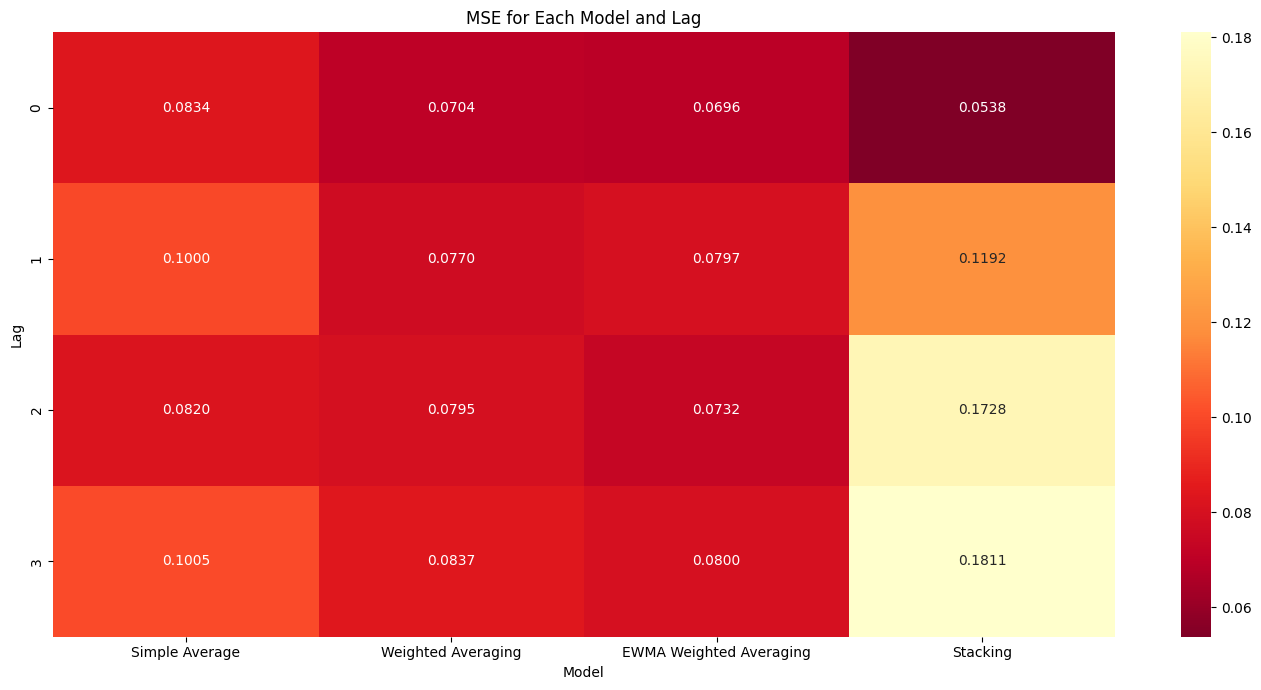

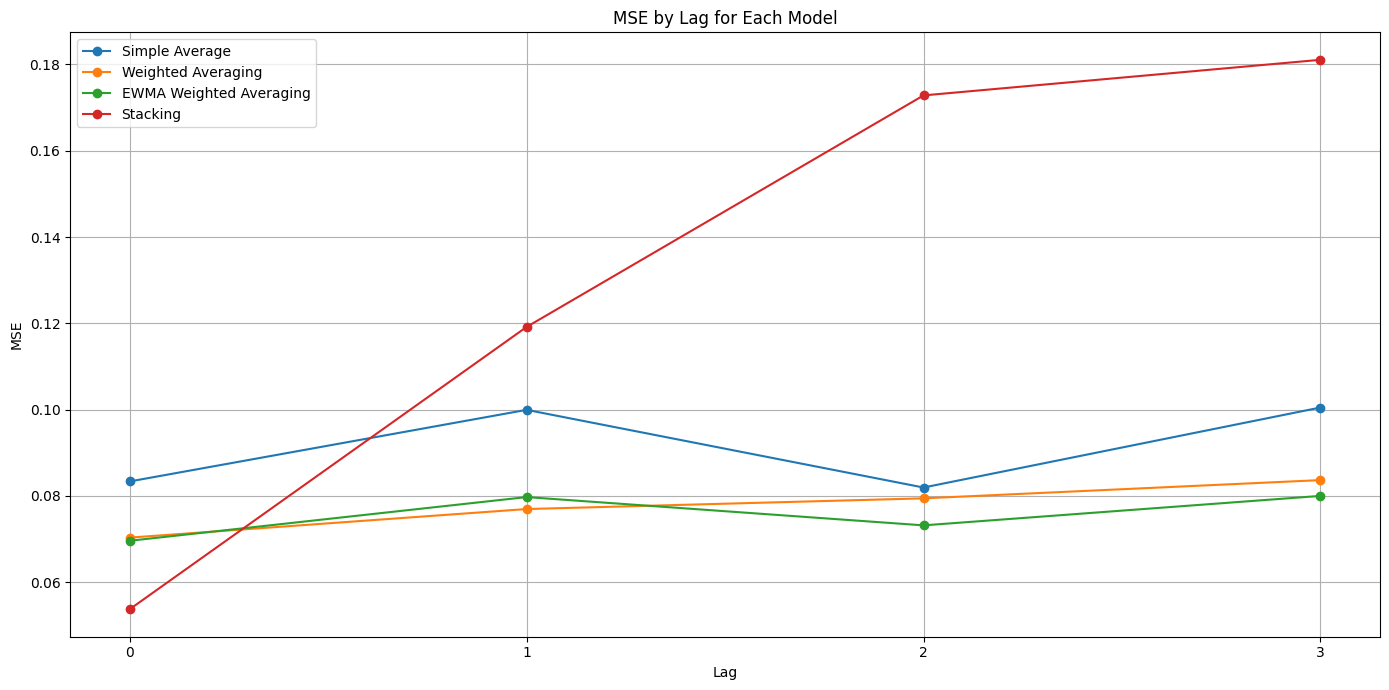


Overall performance (average MSE across all lags):
Simple Average: 0.0914
Weighted Averaging: 0.0776
EWMA Weighted Averaging: 0.0756
Stacking: 0.1317

Best overall method: EWMA Weighted Averaging (Average MSE: 0.0756)


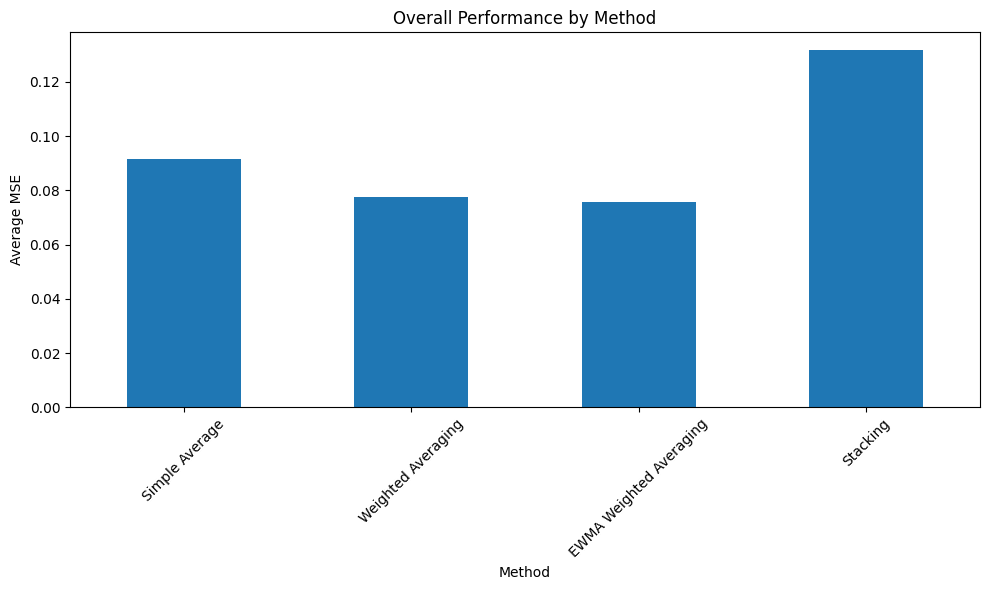

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Update the methods list to include all the models we've implemented
methods = ['Simple Average', 'Weighted Averaging', 'EWMA Weighted Averaging', 'Stacking']

# Create a dictionary to store MSE values for each method and lag
mse_dict = {method: {} for method in methods}

# Print column names for debugging
print("Columns in filtered_data:")
print(filtered_data.columns)


# Calculate MSE for each method and lag
for lag in all_lags:
    print(f"\nProcessing lag {lag}:")
    
    # Simple Average
    col_name = f'avg_{lag}'
    if col_name in filtered_data.columns:
        mse_dict['Simple Average'][lag] = mean_squared_error(filtered_data['target'], filtered_data[col_name])
        print(f"  Simple Average column found: {col_name}")
    else:
        print(f"  Simple Average column not found: {col_name}")
    
    # Weighted Average
    col_name = f'weighted_avg_{lag}'
    if col_name in filtered_data.columns:
        mse_dict['Weighted Averaging'][lag] = mean_squared_error(filtered_data['target'], filtered_data[col_name])
        print(f"  Weighted Average column found: {col_name}")
    else:
        print(f"  Weighted Average column not found: {col_name}")
    
    # EWMA Weighted Average
    col_name = f'ewma_weighted_avg_{lag}'
    if col_name in filtered_data.columns:
        mse_dict['EWMA Weighted Averaging'][lag] = mean_squared_error(filtered_data['target'], filtered_data[col_name])
        print(f"  EWMA Weighted Average column found: {col_name}")
    else:
        print(f"  EWMA Weighted Average column not found: {col_name}")
    
    # Stacking
    col_name = f'stacked_prediction_{lag}'
    if col_name in filtered_data.columns:
        # Remove rows with NaN values in either target or prediction column
        valid_data = filtered_data.dropna(subset=['target', col_name])
        if len(valid_data) > 0:
            mse_dict['Stacking'][lag] = mean_squared_error(valid_data['target'], valid_data[col_name])
            print(f"  Stacking column found: {col_name}")
            print(f"    Rows used for MSE calculation: {len(valid_data)} out of {len(filtered_data)}")
        else:
            print(f"  Stacking column found: {col_name}, but all rows contain NaN values")
            mse_dict['Stacking'][lag] = np.nan
    else:
        print(f"  Stacking column not found: {col_name}")
        mse_dict['Stacking'][lag] = np.nan

# Create a DataFrame from the MSE dictionary
mse_df = pd.DataFrame(mse_dict)

# Print the MSE DataFrame for debugging
print("\nMSE DataFrame:")
print(mse_df)

# Find the best model for each lag
best_models = mse_df.idxmin(axis=1)
best_mse = mse_df.min(axis=1)

# Print the best model for each lag
print("\nBest model for each lag:")
for lag, model in best_models.items():
    print(f"Lag {lag}: {model} (MSE: {best_mse[lag]:.4f})")

# Visualize the performance
plt.figure(figsize=(14, 7))
sns.heatmap(mse_df, annot=True, fmt='.4f', cmap='YlOrRd_r')
plt.title('MSE for Each Model and Lag')
plt.xlabel('Model')
plt.ylabel('Lag')
plt.tight_layout()
plt.show()

# Line plot of MSE for each model across lags
plt.figure(figsize=(14, 7))
for method in methods:
    if method in mse_df.columns:
        plt.plot(mse_df.index, mse_df[method], marker='o', label=method)
plt.title('MSE by Lag for Each Model')
plt.xlabel('Lag')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate overall performance for each method
overall_performance = mse_df.mean()
print("\nOverall performance (average MSE across all lags):")
for method, mse in overall_performance.items():
    print(f"{method}: {mse:.4f}")

# Identify the best overall method
best_overall_method = overall_performance.idxmin()
best_overall_mse = overall_performance.min()
print(f"\nBest overall method: {best_overall_method} (Average MSE: {best_overall_mse:.4f})")

# Bar plot of overall performance
plt.figure(figsize=(10, 6))
overall_performance.plot(kind='bar')
plt.title('Overall Performance by Method')
plt.xlabel('Method')
plt.ylabel('Average MSE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

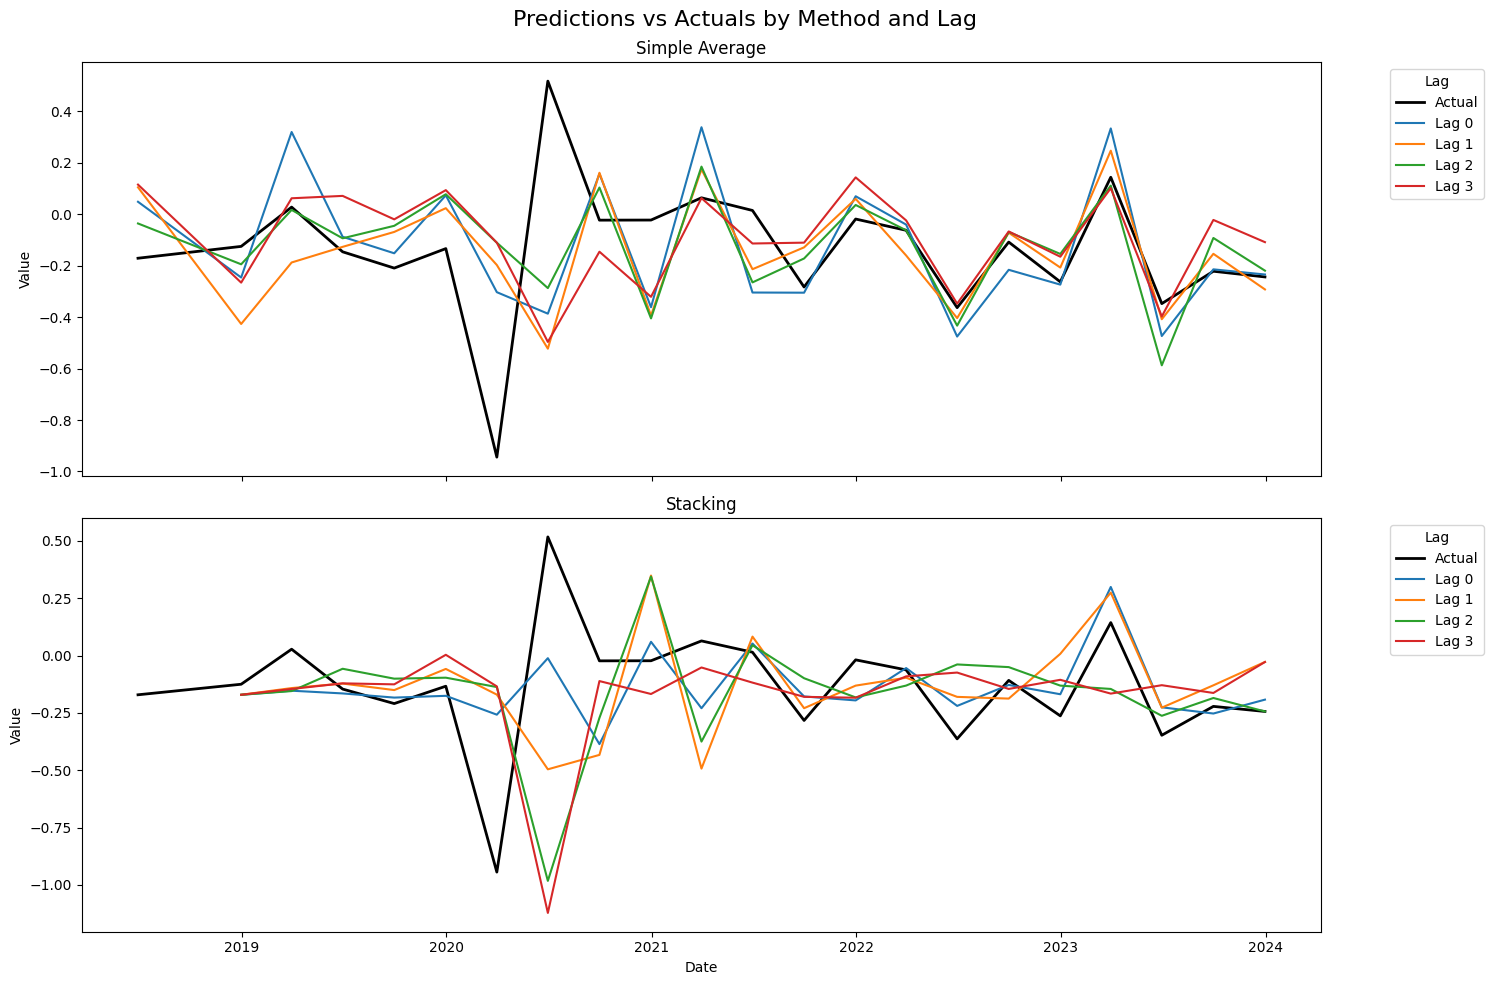

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'filtered_data' contains your predictions and actuals

# Create a new DataFrame for plotting
plot_data = filtered_data[['date', 'target']].copy()

# Define methods and lags
methods = ['avg', 'stacked_prediction']
method_names = ['Simple Average','Stacking']

# Set up the plot
fig, axes = plt.subplots(len(methods), 1, figsize=(15, 5*len(methods)), sharex=True)
fig.suptitle('Predictions vs Actuals by Method and Lag', fontsize=16)

for i, (method, method_name) in enumerate(zip(methods, method_names)):
    # Plot actual values
    sns.lineplot(data=plot_data, x='date', y='target', ax=axes[i], label='Actual', color='black', linewidth=2)
    
    # Plot predictions for each lag
    for lag in all_lags:
        column_name = f'{method}_{lag}'
        if column_name in filtered_data.columns:
            sns.lineplot(data=filtered_data, x='date', y=column_name, ax=axes[i], label=f'Lag {lag}')
    
    axes[i].set_title(method_name)
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Value')
    axes[i].legend(title='Lag', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()



Save result

In [20]:
# Save the final ensemble predictions
filtered_data.to_csv(data_dir / 'final_ensemble_predictions_deseason.csv', index=False)

# If stacking is the best model, you might want to save the meta-model
import joblib
joblib.dump(meta_model, data_dir / 'meta_model_deseason.pkl')

['meta_model_deseason.pkl']